In [193]:
from gwtoolbox import tools_earth
from gwtoolbox.sources_kHz import DNS
from gwtoolbox.functions_earth import rho_sq_core
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.constants import c
from forward import *
from distance import *

In [2]:
# set cosmological parameters
H0 = 70
Om0 = 0.3
T0 = 2.725

In [3]:
# generate desired cosmology
cosmos = tools_earth.set_cosmology(None, H0, Om0, T0)

In [4]:
# R0, tau, m_mean, m_sclae, m_low, m_high, chi_sigma
# R0: merger rate [/yr/Gpc3] 
# tau: Delay time from formation to merger [Gyr]
# mass mean, standard deviation, low, high [solar masses]
# dispersion of effective spin
# be sure to keep these consistent with MOSFIT!
# find sauce to motivate the selected values
BNS_par = [300,3,1.4,0.5,1.1,2.5,0.1]

In [5]:
# summon the desired tool (LIGO)
Tools = tools_earth.Tools(detector_type='ligo', event_type='nsns', population=BNS_par, cosmos=cosmos)

In [6]:
Tools.detector.ante_pattern, Tools.noise

(<bound method LigoLike.ante_pattern of <gwtoolbox.detectors_earth.LigoLike object at 0x000001645A2E9340>>,
 [array([   5.    ,    5.0115,    5.0231, ..., 4977.    , 4988.5   ,
         5000.    ]),
  array([3.99880009e-40, 3.78769444e-40, 3.58799364e-40, ...,
         6.01426576e-46, 6.04176400e-46, 6.06981769e-46])])

In [7]:
# set generator parameters
time_obs = 60*24*365*20 # units of minutes of observation
rho_cri = 8 # signal-to-noise ratio cutoff

In [8]:
tot_num = Tools.total_number(time_obs, rho_cri)
print(tot_num)

481.0021503331345


In [9]:
# returns keys 'z','D','m1','m2','χ','dz','dm1','dm2','dχ','dD','dtb'
list_det = Tools.list_with_errors_df(time_obs, rho_cri, dtp=True)

In [10]:
l = Tools.list_with_iota(list_det)

(array([ 10.,   3.,  16.,  12.,  31.,  34.,  45.,  72.,  99., 136.]),
 array([0.00989748, 0.10867696, 0.20745644, 0.30623592, 0.40501541,
        0.50379489, 0.60257437, 0.70135385, 0.80013333, 0.89891281,
        0.9976923 ]),
 <BarContainer object of 10 artists>)

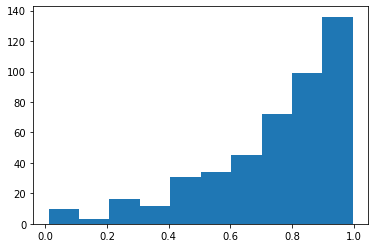

In [11]:
plt.hist(np.cos(l['inc'].to_numpy()))

In [77]:
ninc = []
for i in range(len(l)):
    thet = np.random.uniform(0, np.pi/2)
    phi = np.random.uniform(0, np.pi/2)
    ninc += [np.arccos(np.cos(thet)*np.cos(phi))]

# ninc = [1.0]*1000

In [78]:
pd = [tel_fun(dns, l.iloc[i]['z'], 1.4, 1.4, \
              ninc[i], rho_cri, Tools.detector.ante_pattern, Tools.noise) for i in range(len(l))]

In [101]:
pdr = np.random.uniform(0,1,len(l))
det_idx = pdr<pd
obl = l[det_idx]
nobl = l[[not elem for elem in det_idx]]
obl_inc = np.asarray(ninc)[det_idx]
# obl = l
# obl_inc = [0.0]*1000

In [102]:
len(obl),  len(nobl)

(135, 324)

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.04030231, 0.14030231, 0.24030231, 0.34030231, 0.44030231,
        0.54030231, 0.64030231, 0.74030231, 0.84030231, 0.94030231,
        1.04030231]),
 <BarContainer object of 10 artists>)

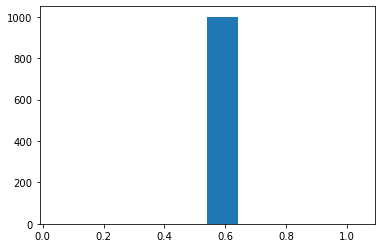

In [69]:
plt.hist(np.cos(np.asarray(ninc)))

In [252]:
nl = 50
no = 50

In [253]:
llb = []
lhb = []
ldm = []
lavg = []
lvar = []
for i in range(nl):
    pmesh, values, positions, vline, dline = pDV_dist(nobl.iloc[i]['D'], \
                                                      np.cos(ninc[i]), 1.4, 1.4, plot=False)
    dpdf = np.sum(pmesh, 1)
    dpdf /= dline**2
    dpdf /= dpdf.max()
    davg = np.average(dline, weights=dpdf/dline)
    dvar = np.average((dline-davg)**2, weights=dpdf)
    dmax = dline[dpdf.argmax()]
    lb = dline[np.abs(dpdf[dline<dmax] - np.exp(-1/2)).argmin()]
    hb = dline[dpdf.argmax() + np.abs(dpdf[dline>dmax] - np.exp(-1/2)).argmin()]
    
#     print(l.iloc[i]['D'], ninc[i]*180/np.pi)
#     plt.plot(dline, dpdf)
#     plt.show()
    
    llb += [dmax-lb]
    lhb += [hb-dmax]
#     print(dmax-lb, hb-dmax)
    ldm += [dmax]
    lavg += [davg]
    lvar += [dvar]

In [254]:
olb = []
ohb = []
odm = []
oavg = []
ovar = []
for i in range(no):
    pmesh, values, positions, vline, dline = pDV_dist(obl.iloc[i]['D'], \
                                                      np.cos(obl_inc[i]), 1.4, 1.4, plot=False)
    dpdf = np.sum(pmesh, 1)
    dpdf /= dline**2
    dpdf /= dpdf.max()
    davg = np.average(dline, weights=dpdf)
#     print(obl.iloc[i]['D']-davg, obl_inc[i])|
    dvar = np.average((dline-davg)**2, weights=dpdf)
    dmax = dline[dpdf.argmax()]
    lb = dline[np.abs(dpdf[dline<dmax] - np.exp(-1/2)).argmin()]
    hb = dline[dpdf.argmax() + np.abs(dpdf[dline>dmax] - np.exp(-1/2)).argmin()]
    
    olb += [dmax-lb]
    ohb += [hb-dmax]
    odm += [dmax]
    oavg += [davg]
    ovar += [dvar]

In [310]:
def v_at_z(z):
    frac = ((z+1)**2-1)/((z+1)**2+0.7)
    return frac*c.value/1e3

In [311]:
def OLSfit(x, y, dy=None):
    """Find the best fitting parameters of a linear fit to the data through the
    method of ordinary least squares estimation. (i.e. find m and b for
    y = m*x + b)

    Args:
        x: Numpy array of independent variable data
        y: Numpy array of dependent variable data. Must have same size as x.
        dy: Numpy array of dependent variable standard deviations. Must be same
            size as y.

    Returns: A list with four floating point values. [m, dm, b, db]
    """
    if dy is None:
        #if no error bars, weight every point the same
        dy = np.ones(x.size)
    denom = np.sum(1 / dy**2) * np.sum((x / dy)**2) - (np.sum(x / dy**2))**2
    m = (np.sum(1 / dy**2) * np.sum(x * y / dy**2) -
         np.sum(x / dy**2) * np.sum(y / dy**2)) / denom
    b = (np.sum(x**2 / dy**2) * np.sum(y / dy**2) -
         np.sum(x / dy**2) * np.sum(x * y / dy**2)) / denom
    dm = np.sqrt(np.sum(1 / dy**2) / denom)
    db = np.sqrt(np.sum(x / dy**2) / denom)
    return([m, dm, b, db])

In [312]:
def OLSfit0(x, y, dy=None):
    """
    Forces y-intercept at zero.
    
    Find the best fitting parameters of a linear fit to the data through the
    method of ordinary least squares estimation. (i.e. find m and b for
    y = m*x + b)

    Args:
        x: Numpy array of independent variable data
        y: Numpy array of dependent variable data. Must have same size as x.
        dy: Numpy array of dependent variable standard deviations. Must be same
            size as y.

    Returns: A list with four floating point values. [m, dm, b, db]
    """
    if dy is None:
        #if no error bars, weight every point the same
        dy = np.ones(x.size)
    denom = np.sum(1 / dy**2) * np.sum((x / dy)**2)
    m = (np.sum(1 / dy**2) * np.sum(x * y / dy**2)) / denom
    dm = np.sqrt(np.sum(1 / dy**2) / denom)
    return([m, dm])

In [313]:
tline = OLSfit0(np.concatenate([nobl['D'].to_numpy()[:nl],\
            obl['D'].to_numpy()[:no]], 0), v_at_z(np.concatenate([nobl['z'].to_numpy()[:nl],\
            obl['z'].to_numpy()[:no]], 0)))

tline1 = OLSfit(np.concatenate([nobl['D'].to_numpy()[:nl],\
            obl['D'].to_numpy()[:no]], 0), v_at_z(np.concatenate([nobl['z'].to_numpy()[:nl],\
            obl['z'].to_numpy()[:no]], 0)))

lline = OLSfit0(np.asarray(lavg[:nl]+oavg[:no]), v_at_z(np.concatenate([nobl['z'].to_numpy()[:nl],\
            obl['z'].to_numpy()[:no]], 0)), dy=np.sqrt(np.asarray(lvar[:nl]+ovar[:no])))
oline = OLSfit0(np.asarray(oavg[:no]), v_at_z(obl['z'].to_numpy()[:no]), dy=np.sqrt(np.asarray(ovar[:no])))

# lline = OLSfit(np.asarray(lavg[:nl]+oavg[:no]), v_at_z(np.concatenate([nobl['z'].to_numpy()[:nl],\
#             obl['z'].to_numpy()[:no]], 0)), dy=None)
# oline = OLSfit(np.asarray(oavg[:no]), v_at_z(obl['z'].to_numpy()[:no]), dy=None)

In [314]:
lline, tline

([80.32552182831841, 0.007366683388392753],
 [73.08891969389389, 0.0003592331729963455])

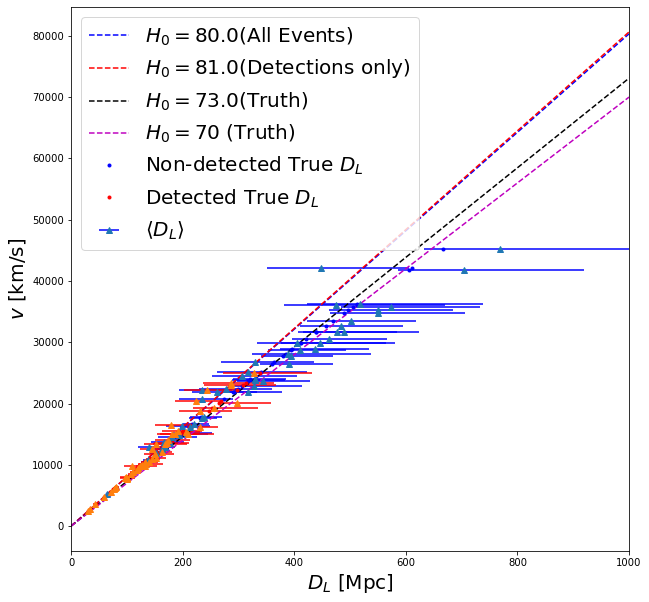

In [316]:
plt.figure(figsize=(10,10))

xrange = np.linspace(0, 1000)
plt.plot(xrange, lline[0]*xrange, '--b', label='$H_0=$' + str(np.around(lline[0])) + '(All Events)')
plt.plot(xrange, oline[0]*xrange, '--r', label='$H_0=$' + str(np.around(oline[0])) + '(Detections only)')
plt.plot(xrange, tline[0]*xrange, '--k', label='$H_0=$' + str(np.around(tline[0])) + '(Truth)')

plt.plot(xrange, 70*xrange, '--m', label='$H_0=70$ (Truth)')


asymmetric_error = np.array(list(zip(llb[:nl], lhb[:nl]))).T
asymmetric_error2 = np.array(list(zip(olb[:no], ohb[:no]))).T
plt.errorbar(lavg[:nl], v_at_z(nobl['z'].to_numpy()[:nl]), xerr=asymmetric_error, fmt='^', ecolor = 'blue', \
             label=r'$\langle D_L\rangle$')
plt.errorbar(oavg[:no], v_at_z(obl['z'].to_numpy()[:no]), xerr=asymmetric_error2, fmt='^', ecolor = 'red')

plt.plot(nobl['D'].to_numpy()[:nl], v_at_z(nobl['z'].to_numpy()[:nl]), '.b', label='Non-detected True $D_L$')
plt.plot(obl['D'].to_numpy()[:no], v_at_z(obl['z'].to_numpy()[:no]), '.r', label='Detected True $D_L$')

# plt.plot(lavg[:nl], nobl['z'].to_numpy()[:nl], '^b', label=r'$\langle D \rangle$')
# plt.plot(oavg[:no], obl['z'].to_numpy()[:no], '^r')

# plt.ylim(0, 0.12)
plt.xlim(0, 1000)

plt.legend(fontsize=20, loc='upper left')

plt.ylabel('$v$ [km/s]', fontsize=20)
plt.xlabel('$D_L$ [Mpc]', fontsize=20)

plt.show()

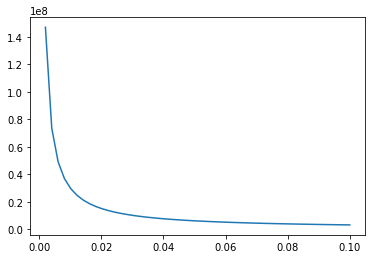

In [280]:
plt.plot(np.linspace(0, 0.1), v_at_z(np.linspace(0, 0.1)))

In [42]:
obl

,z,D,m1,m2,χ,dz,dm1,dm2,dχ,dD,dtb,inc
6,0.044180,195.590285,1.622728,1.327813,-0.039551,0.022090,0.081136,0.066391,0.000245,100.933245,0.281,0.722487
7,0.036370,160.098208,1.384039,1.658767,-0.000706,0.018185,0.069202,0.082938,0.000774,82.187830,0.408,0.936860
8,0.039283,173.291639,2.331767,1.375733,0.136948,0.019642,0.116588,0.068787,0.000179,89.135645,0.445,1.240826
10,0.027442,120.000010,1.933195,1.323218,-0.049138,0.013721,0.096660,0.066161,0.000148,61.225384,0.604,0.389488
11,0.028271,123.704160,1.222266,1.795858,0.135972,0.014136,0.061113,0.089793,0.000121,63.151897,0.548,0.444065
...,...,...,...,...,...,...,...,...,...,...,...,...
321,0.037272,164.178074,1.744589,1.616140,0.285825,0.018636,0.087229,0.080807,0.000185,84.333717,0.451,0.626587
322,0.047120,209.051193,1.804839,1.255438,0.013834,0.023560,0.090242,0.062772,0.002388,108.087670,0.239,0.928085
325,0.008338,35.940644,1.610629,1.253898,-0.040824,0.004169,0.080531,0.062695,0.000051,18.085013,0.926,0.625316
337,0.021021,91.484795,1.759758,1.823448,0.055301,0.010511,0.087988,0.091172,0.000091,46.464792,0.758,0.721677


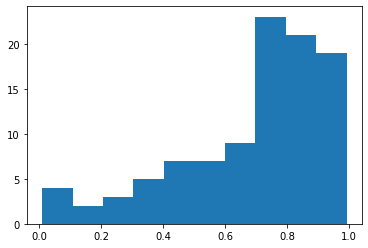

In [43]:
plt.hist(np.cos(obl['inc']))
plt.show()

In [44]:
obl.iloc[2]
obl_npy = np.zeros((100, 8))

for i in range(len(obl)):
    event = obl.iloc[i]
    v0 = np.cos(event['inc'])
    M1 = event['m1']
    M2 = event['m2']
    if M1<M2:
        Q = M1/M2
    else:
        Q = M2/M1
    Mchirp = ((M1*M2)**3/(M1+M2))**(1/5)
    fixed_params = {"ebv": 2.2, "rvhost": 3.1, "frad": 0.999, "nnhost": 1e18,\
              "texplosion": -0.01, "temperature": 2500, "kappa_red": 10,\
              "kappa_blue": 0.5, "kappagamma": 10000.0, "Mchirp": Mchirp,\
              "q": Q, "cos_theta": v0, "cos_theta_open": 0.707107,\
              "disk_frac": 0.15, "radius_ns": 11.0, "alpha": 1.0,\
              "Mtov": 2.2, "cos_theta_cocoon": 0.5, "tshock": 1.7,\
              "temperature_shock": 100, "lumdist": event['D'], "redshift": event['z']}
    p = light_curve(my_fitter, fixed_params)
    print(p)
    if p[0] == True:
        det = 1.0
    else:
        det = 0.0
        
        
    obl_npy[i][0] = event['z']
    obl_npy[i][1] = event['D']
    obl_npy[i][2] = event['m1']
    obl_npy[i][3] = event['m2']
    obl_npy[i][4] = event['dm1']
    obl_npy[i][5] = event['dm2']
    obl_npy[i][6] = v0
    obl_npy[i][7] = det


Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]




Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(True, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing o


Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Lo


Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2`


Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 3


Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(False, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loa


Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(True, 1)

Basic model fil

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `de


Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading mo

All walkers written.
(True, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loadin


Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(True, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data


Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [


Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3`


Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading modul


Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(False, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loa


Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(False, 1)

Basic model fi


Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]




Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]


(False, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes


Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(True, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data


Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [


Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3`


Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading modul


Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(False, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loa


Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(True, 1)

Basic model fil


Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]




Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]


(False, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes


Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(True, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data


Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [


Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3`


Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading modul


Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(False, 1)

Basic model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\model.json
Model file:
  C:\Users\sgagn\Anaconda3\envs\kn\Lib\site-packages\mosfit\models\bns_generative\bns_generative.json
Parameter file:
  models\bns_generative\parameters.json
No event specified, generating dummy data.

Loading data...

Loading module `transient` [ 0% ]
Constructing observation array [ 0.0% ]
Constructing observation array [ 25.0% ]
Constructing observation array [ 50.0% ]
Constructing observation array [ 75.0% ]

Loading module `lumdist` [ 2% ]

Loading module `redshift` [ 3% ]

Loading module `alltimes` [ 5% ]

Loading module `texplosion` [ 7% ]

Loa


Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]

Loading module `variance` [ 82% ]

Loading module `codeltatime` [ 83% ]

Loading module `codeltalambda` [ 85% ]

Loading module `photometry` [ 87% ]

Loading module `fitkernel` [ 88% ]

Loading module `diagonal` [ 90% ]

Loading module `oakernel` [ 92% ]

Loading module `aokernel` [ 93% ]

Loading module `fullkernel` [ 95% ]

Loading module `likelihood` [ 97% ]

Loading module `fitlc` [ 98% ]

Finding bands...
Loading bands complete.

Bands being used for current transient:
  SLOAN/SDSS.z [System: AB]

2 measurements, 0 free parameters.
Initial draws completed!

Constructing output...
All walkers written.
(True, 1)

Basic model fil


Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]

Loading module `rprocess2` [ 53% ]

Loading module `blackbody` [ 55% ]

Loading module `temperature_floor1` [ 57% ]

Loading module `diffusion2` [ 58% ]

Loading module `rprocess3` [ 60% ]

Loading module `blackbody1` [ 62% ]

Loading module `temperature_floor2` [ 63% ]

Loading module `diffusion3` [ 65% ]

Loading module `blackbody2` [ 67% ]

Loading module `temperature_floor3` [ 68% ]

Loading module `ebv` [ 70% ]

Loading module `rvhost` [ 72% ]

Loading module `nhhost` [ 73% ]

Loading module `blackbody3` [ 75% ]

Loading module `losextinction` [ 77% ]

Loading module `default_upper_limit_error` [ 78% ]

Loading module `default_no_error_bar_error` [ 80% ]




Loading module `resttimes` [ 8% ]

Loading module `Mchirp` [ 10% ]

Loading module `q` [ 12% ]

Loading module `disk_frac` [ 13% ]

Loading module `radius_ns` [ 15% ]

Loading module `alpha` [ 17% ]

Loading module `Mtov` [ 18% ]

Loading module `errMdyn` [ 20% ]

Loading module `errMdisk` [ 22% ]

Loading module `densetimes` [ 23% ]

Loading module `frad` [ 25% ]

Loading module `kappa_blue` [ 27% ]

Loading module `cos_theta` [ 28% ]

Loading module `cos_theta_open` [ 30% ]

Loading module `cos_theta_cocoon` [ 32% ]

Loading module `s` [ 33% ]

Loading module `tshock` [ 35% ]

Loading module `bns_ejecta_generative` [ 37% ]

Loading module `kappa_red` [ 38% ]

Loading module `kappagamma` [ 40% ]

Loading module `temperature_shock` [ 42% ]

Loading module `aspherical_kilonova` [ 43% ]

Loading module `shock_cocoon` [ 45% ]

Loading module `rprocess` [ 47% ]

Loading module `temperature` [ 48% ]

Loading module `temperature_floor` [ 50% ]

Loading module `diffusion_aspherical` [ 52% ]


(False, 1)


In [53]:
det = obl_npy[obl_npy[:,-1]==1.0]

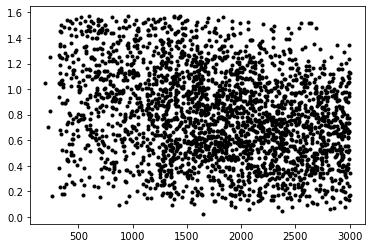

In [88]:
plt.plot(ld['D'], ld['inc'], '.k')
# plt.plot(obl['D'], obl['inc'], '.r')
# plt.plot(det[:,1], np.arccos(det[:,-2]), '.b')
plt.show()

In [22]:
from astropy import cosmology as cosmo
from astropy import units as u

In [24]:
u = cosmo.FlatLambdaCDM(70, 0.3)

In [26]:
u.luminosity_distance(0.077933)

<Quantity 353.37355055 Mpc>

In [89]:
dns = DNS(cosmos)


In [90]:
def tel_fun(dns, z, m1, m2, iota, rho_cri, ant_fun, noise_tab):
    """
    The telescope function of Laser Interferometers and kHz sources.

    Parameters:
      z (float): The redshift of the GW source
      m1 (float): Red-shifted masses of the BHB
      m2 (float): Red-shifted masses of the BHB
      #chi (float): spin
      iota (float): inclination angle in radians
      rho_cri (float): The detection SNR threshold
      ant_fun (function): antenna pattern
      noise_tab (array of dtype float): noise function for detector

    Returns:
      (float): The probability of detection
    """
    # both masses should be intrinsic here.
    Mch = (m1*m2)**(5/6)/(m1+m2)**(1/5)
    
    random_angles_more=np.loadtxt("angles_more.dat")
    theta_array_more = random_angles_more[:,0]
    varphi_array_more = random_angles_more[:,1]
    iota_array_more = np.ones(len(random_angles_more[:,1]))*iota
    psi_array_more = random_angles_more[:,3]
    F = ant_fun(theta_array_more, varphi_array_more, psi_array_more)
    A_array = dns.mod_norm(Mch*(1+z), F, iota_array_more, z)
    
    f_up = dns.freq_limit(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    f2=dns.freq_limit_merger(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    f3=dns.freq_limit_ringdown(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    freq_sig=dns.freq_sigma(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    f1=f_up
    rho_sq_core_value = rho_sq_core(noise_tab, dns.mod_shape, f_up=f_up)
    
    if len(A_array.shape)==2:
        rho_sq_array=4.*np.einsum('i...,i->i...',A_array**2,rho_sq_core_value)
        heav_array = np.heaviside(rho_sq_array-rho_cri**2,0)

        return np.mean(heav_array,axis=1)
    else: 
        rho_sq_array = np.array(4.*A_array**2*rho_sq_core_value)
        heav_array = np.heaviside(rho_sq_array-rho_cri**2,0)
        return np.mean(heav_array)

In [40]:
iota_array = np.linspace(0, np.pi/2, 100)
pd = [tel_fun(dns, 0.001, 1.4, 1.4, iota, rho_cri, Tools.detector.ante_pattern, Tools.noise) for iota in iota_array]

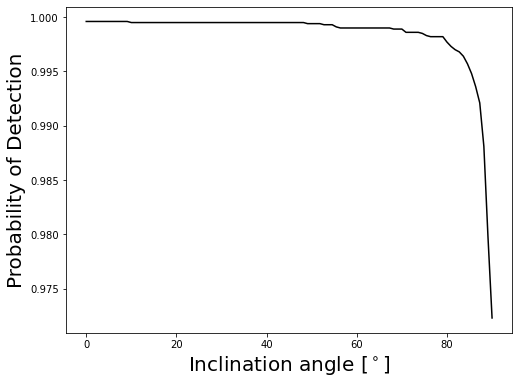

In [41]:
plt.figure(figsize=(8,6))
plt.plot(iota_array*180/np.pi, pd, '-k')
plt.ylabel('Probability of Detection', fontsize=20)
plt.xlabel('Inclination angle [$^\circ$]', fontsize=20)
plt.show()

In [38]:
for i in [1,2,3,4]:
    if i == 3:
        continue
    print(i)

1
2
4


In [39]:
pd

[0.1295,
 0.1295,
 0.1294,
 0.1293,
 0.1289,
 0.1281,
 0.1271,
 0.1264,
 0.1254,
 0.1239,
 0.1228,
 0.1213,
 0.1194,
 0.1174,
 0.1158,
 0.114,
 0.1114,
 0.1094,
 0.1075,
 0.1043,
 0.1022,
 0.0994,
 0.0968,
 0.0933,
 0.0916,
 0.0874,
 0.0836,
 0.0804,
 0.0773,
 0.0724,
 0.0697,
 0.0662,
 0.0633,
 0.0597,
 0.0567,
 0.0534,
 0.0493,
 0.0464,
 0.0434,
 0.0385,
 0.0348,
 0.0313,
 0.0284,
 0.0249,
 0.0216,
 0.0193,
 0.0164,
 0.0139,
 0.0118,
 0.0104,
 0.0081,
 0.0067,
 0.0047,
 0.0032,
 0.0023,
 0.0011,
 0.0004,
 0.0003,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

(array([1867., 1348., 1211., 1011.,  913.,  841.,  765.,  733.,  654.,
         657.]),
 array([4.00330028e-05, 1.00014688e-01, 1.99989343e-01, 2.99963999e-01,
        3.99938654e-01, 4.99913309e-01, 5.99887964e-01, 6.99862620e-01,
        7.99837275e-01, 8.99811930e-01, 9.99786585e-01]),
 <BarContainer object of 10 artists>)

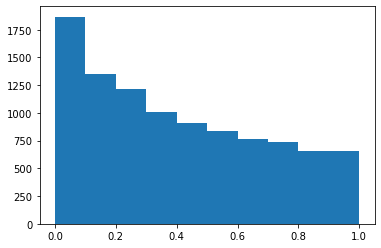

In [218]:
thet = np.random.uniform(0, np.pi/2, 10000)
phi = np.random.uniform(0, np.pi/2, 10000)
plt.hist(np.cos(thet)*np.cos(phi))